# Setup

In [77]:
import IPython
import collections
from dataclasses import dataclass
import glob
import sys
import gzip
import pathlib
import json

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [78]:
# Summary statistics of UMI counts for one cell
@dataclass
class CellStat:
    humanGenes: int = 0
    mouseGenes: int = 0
    humanUmis: int = 0
    mouseUmis: int = 0

# Input data

In [79]:
#Parameter defaults
soloDir = "Solo.out"
demuxFn = "demuxMetrics.json"
sampleName = ""
fastqName = ""
features = "GeneFull_Ex50pAS"
filtered = "raw"

threshold = None

In [81]:
fastqName = fastqName or sampleName
threshold = int(threshold) if threshold else None

display(IPython.display.Markdown(f"# SAMPLE: {sampleName}"))

# SAMPLE: sdBarn

In [6]:
genes = pd.read_csv(f"{soloDir}/{features}/{filtered}/features.tsv", sep="\t", header=None)
genes.columns=["Id", "Name", "Type"]
genes.index = genes.index + 1
genes['species'] = genes.Id.map(lambda x: ["mm","hs"][x.startswith("ENSG")])

In [7]:
cellBarcodes = pd.read_csv(f"{soloDir}/{features}/{filtered}/barcodes.tsv", sep="\t", header=None)
cellBarcodes.columns=["Barcode"]
cellBarcodes.index = cellBarcodes.index + 1

In [8]:
# Read UMI counts from matrix and aggregate statistics per cell
f = open(glob.glob(f"{soloDir}/{features}/{filtered}/matrix.mtx")[0])
f.readline();f.readline();f.readline()
cells = collections.defaultdict(CellStat)
for l in f:
    line = l.split()
    gene = int(line[0])
    cell = int(line[1])
    count = int(line[2])
    if genes.species[gene] == "hs":
        cells[cell].humanGenes += 1
        cells[cell].humanUmis += count
    elif genes.species[gene] == "mm":
        cells[cell].mouseGenes += 1
        cells[cell].mouseUmis += count
    else:
        print(genes.iloc[gene], file=sys.stderr)
f.close()

cellStats = pd.DataFrame(cells.values(), index=[cellBarcodes.Barcode[i] for i in cells])

# Metrics

In [20]:

# Metrics from STARSolo that do not depend on cell threshold
def loadStarStats(fn):
    starStats = {}
    for l in open(fn):
        line = l.strip().split(',')
        starStats[line[0]] = line[1]
    stats = {}
    stats['Total Reads'] = f"{int(starStats['Number of Reads']):,}"
    stats['Saturation'] = f"{float(starStats['Sequencing Saturation']):.2}"
    stats['Reads Mapped to Genome'] = f"{float(starStats['Reads Mapped to Genome: Unique+Multiple']):.1%}"
    val = starStats[f"Reads Mapped to {features}: Unique+Multiple {features}"]
    stats['Reads Mapped to Transcripts'] = f"{float(val):.1%}"
    val = starStats[f"Reads Mapped to {features}: Unique {features}"]
    stats['Reads Mapped to unique Transcript'] = f"{float(val):.1%}"
    stats['STAR Cells'] = starStats["Estimated Number of Cells"]
    return stats

starStats = loadStarStats(glob.glob(f"{soloDir}/{features}/Summary.csv")[0])
table = "Metric | Value\n--- | ---\n"
for s in starStats:
    if s in ['STAR Cells']: continue
    table += f"{s} | {starStats[s]}\n"
display(IPython.display.Markdown(f"### STARSolo metrics"))
display(IPython.display.Markdown(table))


### STARSolo metrics

Metric | Value
--- | ---
Total Reads | 47,876,239
Saturation | 0.52
Reads Mapped to Genome | 91.6%
Reads Mapped to Transcripts | 76.2%
Reads Mapped to unique Transcript | 68.2%


### Cell Metrics

In [17]:
# Per cell metrics from STARSolo 
cellReadStats = pd.read_csv(glob.glob(f"{soloDir}/{features}/CellReads.stats")[0], sep='\t', index_col='CB')
cellReadStats = cellReadStats[1:] # First row reads without valid cell-barcodes

In [55]:
cellStats['reads'] = cellReadStats.cbMatch
cellStats['mappedReads'] = cellReadStats.genomeU / cellStats['reads']
cellStats['geneReads'] = cellReadStats.featureU + cellReadStats.featureM
cellStats['exon'] = cellReadStats.exonic / cellStats['geneReads']
cellStats['antisense'] = (cellReadStats.exonicAS + cellReadStats.intronicAS) / cellStats['geneReads']

cellStats['mito'] = cellReadStats.mito / (cellReadStats.genomeU + cellReadStats.genomeM)

cellStats['genes'] = cellStats[["humanGenes", "mouseGenes"]].max(1)
cellStats['umis'] = cellStats[["humanUmis", "mouseUmis"]].max(1)    
cellStats.sort_values('umis', ascending=False, inplace=True)
if not threshold:
    ncells = int(starStats['STAR Cells'])
    threshold = max(100, cellStats.umis[ncells-1])
cellStats['pass'] = cellStats.umis >= threshold
cells = cellStats[cellStats['pass']]


Text(0, 0.5, 'UMIs')

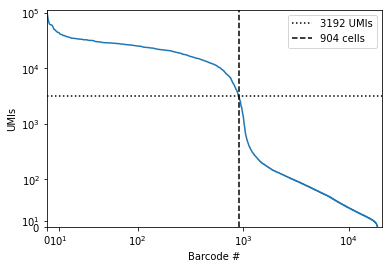

In [21]:
ax = plt.gca()
ax.plot(range(len(cellStats.index)), cellStats.umis, label=f"{sampleName}")
ax.axhline(cells.umis.min(), linestyle=':', label=f"{cells.umis.min()} UMIs", color='black')
ax.axvline(len(cells.index), linestyle='--', color='black', label=f"{len(cells.index)} cells")

ax.legend()
ax.set_xscale('symlog', linthresh=50, linscale=0.5)
ax.set_yscale('symlog', linthresh=50, linscale=0.5)
ax.set_xlim(0,len(cellStats.index)*1.1)
ax.set_ylim(0,cellStats.umis.max()*1.1)
ax.set_xlabel('Barcode #')
ax.set_ylabel('UMIs')

In [29]:
def stat(cellTab):
    cells = cellTab[cellTab['pass']]
    stats = {}
    stats['Cell Threshold']=cells.umis.min()
    stats['Cells above threshold']=len(cells)
    stats['Median UMIs per cell']=f"{cells.umis.median():,.0f}"
    stats['Median Genes per cell']=f"{cells.genes.median():,.0f}"
    return stats

starStats = stat(cellStats)    
table = "Metric | Value\n--- | ---\n"
for s in starStats:
    table += f"{s} | {starStats[s]}\n"
display(IPython.display.Markdown(table))

Metric | Value
--- | ---
Cell Threshold | 3192
Cells above threshold | 904
Median UMIs per cell | 13,319
Median Genes per cell | 5,357


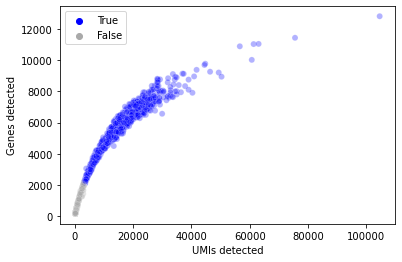

In [30]:
plotCells = cellStats[:cellStats['pass'].sum()*2]
if len(plotCells.index) > 5000:
    plotCells = plotCells.sample(5000)

ax = plt.figure().gca()
ax = sns.scatterplot(x=plotCells.umis, y=plotCells.genes, hue=cellStats['pass'], hue_order=[True, False], palette=['blue', 'darkgray'], alpha=0.3)
ax.set_title(f"{sampleName}", weight='semibold');
ax.set_xlabel('UMIs detected')
ax.set_ylabel('Genes detected');
ax.legend()

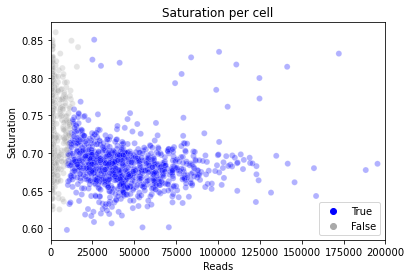

In [31]:
ax = plt.figure().gca()
ax = sns.scatterplot(x=plotCells.reads, y=1-(plotCells.umis / plotCells.reads), hue=cellStats['pass'], hue_order=[True, False], palette=['blue', 'darkgray'], alpha=0.3)
ax.set_title(f"{sampleName}", weight='semibold');
ax.set_xlabel('Reads')
ax.set_xlim(0,200000)
ax.set_ylabel('Saturation');
ax.set_title("Saturation per cell")
ax.legend()

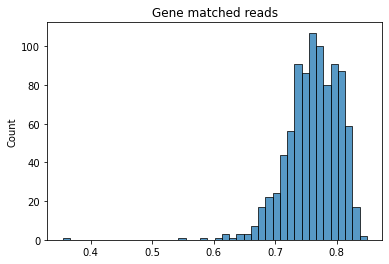

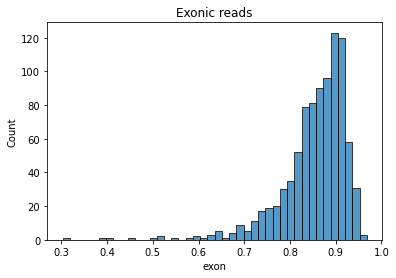

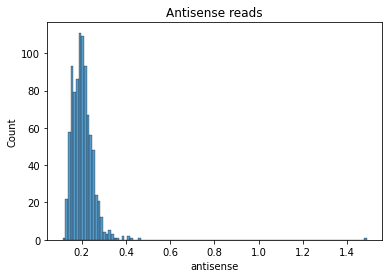

In [56]:
ax = plt.figure().gca()
ax = sns.histplot(cells.geneReads / cells.reads)
ax.set_title("Gene matched reads");

ax = plt.figure().gca()
ax = sns.histplot(cells.exon)
ax.set_title("Exonic reads");

ax = plt.figure().gca()
ax = sns.histplot(cells.antisense)
ax.set_title("Antisense reads");

if cells.mito.any():
    ax = plt.figure().gca()
    ax = sns.histplot(cells.mito)
    ax.set_title("Mito. reads");

### Barnyard

In [73]:
def scoreBarn(tab, cellThres):
    tab['species'] = "None"
    tab['minorFrac'] = tab[['humanUmis', 'mouseUmis']].min(1) / tab[['humanUmis', 'mouseUmis']].sum(1)
    tab.loc[tab['pass'] & (tab.humanUmis > tab.mouseUmis) & (tab.minorFrac < 0.3), 'species'] = "Human"
    tab.loc[tab['pass'] & (tab.mouseUmis > tab.humanUmis) & (tab.minorFrac < 0.3), 'species'] = "Mouse"

    backHuman = tab[(tab.species == 'Mouse')].minorFrac.mean()
    backMouse = tab[(tab.species == 'Human')].minorFrac.mean()
    print(backHuman, backMouse)
    minHuman = minMouse = maxHuman = maxMouse = cellThres
    if (tab.species == 'Human').any() and (tab.species == 'Mouse').any():
        maxHuman = np.percentile(cellStats.humanUmis[cellStats.species=='Human'], 90)
        minHuman = max(10, int(maxHuman * backHuman * 5))
        maxMouse = np.percentile(cellStats.mouseUmis[cellStats.species=='Mouse'], 90)
        minMouse = max(10, int(maxMouse * backMouse * 5))

    tab.loc[(tab.humanUmis < minHuman) & (tab.mouseUmis < minMouse), 'species'] = "None"
    tab.loc[(tab.humanUmis >= minHuman), 'species'] = "Human"
    tab.loc[(tab.mouseUmis >= minMouse), 'species'] = "Mouse"
    tab.loc[(tab.humanUmis >= minHuman) & (tab.mouseUmis >= minMouse), 'species'] = "Mixed"

    tab.loc[(tab.species == 'Mixed') & (tab.humanUmis > tab.mouseUmis) & (tab.minorFrac < backHuman * 3), 'species'] = 'Ambig.'
    tab.loc[(tab.species == 'Mixed') & (tab.mouseUmis > tab.humanUmis) & (tab.minorFrac < backMouse * 3), 'species'] = 'Ambig.'
    tab.loc[(tab.species == 'Human') & (tab.minorFrac >= max(0.1, backMouse * 3)), 'species'] = 'Ambig.'
    tab.loc[(tab.species == 'Mouse') & (tab.minorFrac >= max(0.1, backHuman * 3)), 'species'] = 'Ambig.'

def barnStats(barnTab):    
    tab = barnTab[barnTab['pass'] & (barnTab['species'] != 'Ambiguous')]
    ncells = len(tab.index)
    stats = {}
    humanCells = (tab.species=='Human').sum() / ncells
    mouseCells = (tab.species=='Mouse').sum() / ncells
    mixedCells = (tab.species=='Mixed').sum() / ncells
    stats["Human cells"] = f"{humanCells:.1%}"
    stats["Mouse cells"] = f"{mouseCells:.1%}"
    stats["Mixed cells"] = f"{mixedCells:.1%}"
    #stats["Ambiguous cells"] = f"{((barnTab.species=='Ambiguous').sum() / ncells):.1%}"
    stats["Estimated doublets"] = f"{min(1, mixedCells / (2*humanCells*mouseCells)):.1%}"
    stats["Background"] = f"{tab[tab.species != 'Mixed'].minorFrac.median():.2%}"
    return stats

In [74]:
scoreBarn(cellStats, cellStats.umis[cellStats['pass']].min())
stats = barnStats(cellStats)
table = "Metric | Value\n--- | ---\n"
for s in stats:
    table += f"{s} | {stats[s]}\n"
display(IPython.display.Markdown(table))

0.05484063919997005 0.03213066223466486


Metric | Value
--- | ---
Human cells | 42.8%
Mouse cells | 43.5%
Mixed cells | 1.5%
Estimated doublets | 4.2%
Background | 3.49%


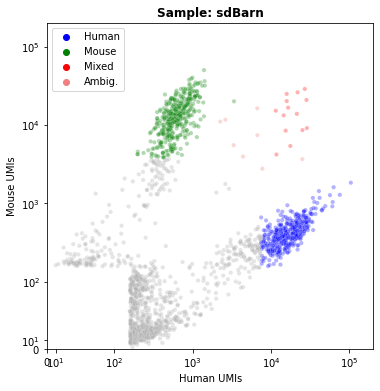

In [75]:
plotCells = cellStats[:cellStats['pass'].sum()*2]
if len(plotCells.index) > 5000:
    plotCells = plotCells.sample(5000)

fig = plt.figure(figsize=(6,6))
ax = sns.scatterplot(x=plotCells.humanUmis+1, y=plotCells.mouseUmis+1, hue=plotCells.species, ax=fig.gca(), hue_order=['Human', 'Mouse', 'Mixed', 'Ambig.', 'None'], palette=['blue', 'green', 'red', 'lightcoral', 'darkgray'], alpha=0.3, s=18)
ax.set_xscale('symlog', linthresh=50, linscale=0.5)
ax.set_yscale('symlog', linthresh=50, linscale=0.5)
maxLim = max(ax.get_xlim()[1], ax.get_ylim()[1]) * 1.25
ax.set_xlim(0, maxLim)
ax.set_ylim(0, maxLim)
ax.set_aspect('equal', adjustable='box')

h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], loc='upper left')
ax.set_title(f"Sample: {sampleName}", weight='semibold');

ax.set_xlabel("Human UMIs")
ax.set_ylabel("Mouse UMIs");

# Barcodes

In [84]:
if fastqName != sampleName:
    display(IPython.display.Markdown(f"## Fastq Sample: {fastqName}"))

if demuxFn:    
    display(IPython.display.Markdown(f"### Barcodes"))
    metrics = json.load(open(demuxFn))
    table = "Barcode | Match | Reads\n--- | --- | --- \n"
    for bc,val in metrics["barcodes"].items():
        for key,cnt in val.items():
            table += f"{bc} | {key} | {cnt[1]} \n"
    display(IPython.display.Markdown(table))

    display(IPython.display.Markdown(f"### Barcode reads"))
    table = "Type | Reads\n--- | ---\n"
    for key,cnt in metrics["reads"].items():
            table += f"{key} | {cnt[1]} \n"
    display(IPython.display.Markdown(table))

    if fastqName != sampleName:
        display(IPython.display.Markdown(f"### Fastq Sample demux"))
        table = "Sample | Reads\n--- | ---\n"
        for sample in metrics["samples"].values():
                table += f"{sample['name']} | {sample['reads'][1]} \n"
        display(IPython.display.Markdown(table))

## Fastq Sample: calico

### Barcodes

Barcode | Match | Reads
--- | --- | --- 
P7 | Exact | 96.3% 
P7 | Corrected | 1.9% 
P7 | Ambiguous | 0.0% 
P7 | NoMatch | 1.8% 
lig | Exact | 97.2% 
lig | Corrected | 1.6% 
lig | Ambiguous | 0.0% 
lig | NoMatch | 0.8% 
lig | Error | 0.3% 
rt | Exact | 90.7% 
rt | Corrected | 1.8% 
rt | Ambiguous | 0.0% 
rt | NoMatch | 3.0% 
rt | Error | 4.5% 
umi | Random | 97.8% 
umi | Filtered | 0.0% 
umi | Error | 2.2% 


### Barcode reads

Type | Reads
--- | ---
Pass | 91.0% 
BarcodeError | 4.5% 
LinkerError | 1.6% 
SequenceError | 2.9% 


### Fastq Sample demux

Sample | Reads
--- | ---
Unknown | 0.0% 
sdBarn | 9.4% 
K562-F2C | 13.8% 
K562-C2F | 26.4% 
oldFibro | 0.6% 
youngFibro | 42.3% 


## Barcoding levels

In [60]:
cellStats['ligInd'] = [b[0:10] for b in cellStats.index]
cellStats['rtInd'] = [b[10:20] for b in cellStats.index]
cellStats['pcrInd'] = [b[20:28] for b in cellStats.index]


In [61]:
def plot_level(cells, index):
    cnts = index.value_counts().sort_values()

    fig, axes = plt.subplots(1,2, sharey=True, figsize=(12,10))
    
    ax = sns.countplot(y=index, order=cnts.index, ax=axes[0])
    ax.set_ylabel('')
    ax.set_xlabel("Number of cells")
    ax.tick_params(axis='y', labelsize=12)
    ax.set_yticklabels(cnts.index, fontfamily='monospace');

    ax = sns.boxplot(x=cells.umis, y=index, order=cnts.index, ax=axes[1])
    ax.set_ylabel('')
    ax.set_xlabel("Unique Fragments per cell")
    ax.set_xscale('log')
    ax.set_xlim(1000,100000)
    ax.tick_params(axis='y', labelsize=12);
    return fig

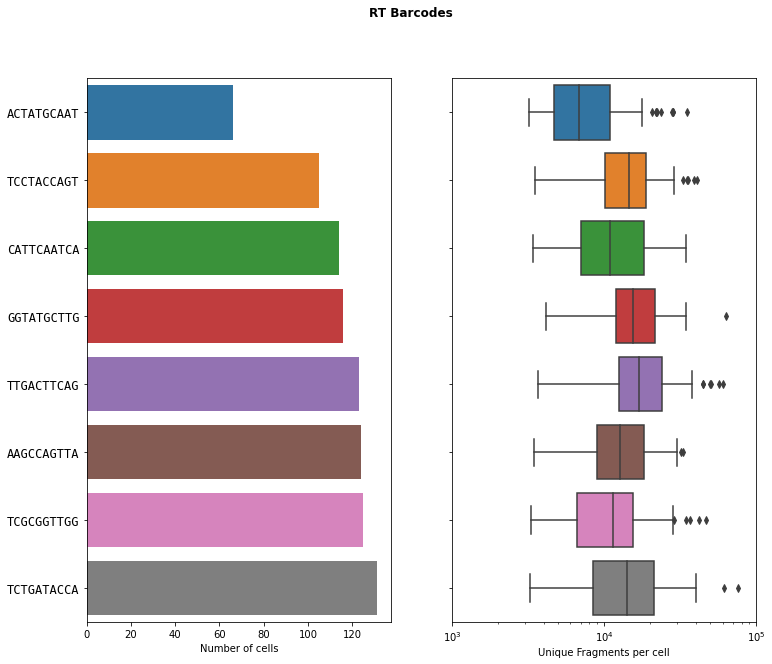

In [62]:
fig = plot_level(cellStats[cellStats['pass']], cellStats.rtInd[cellStats['pass']])
fig.suptitle("RT Barcodes", weight='semibold');


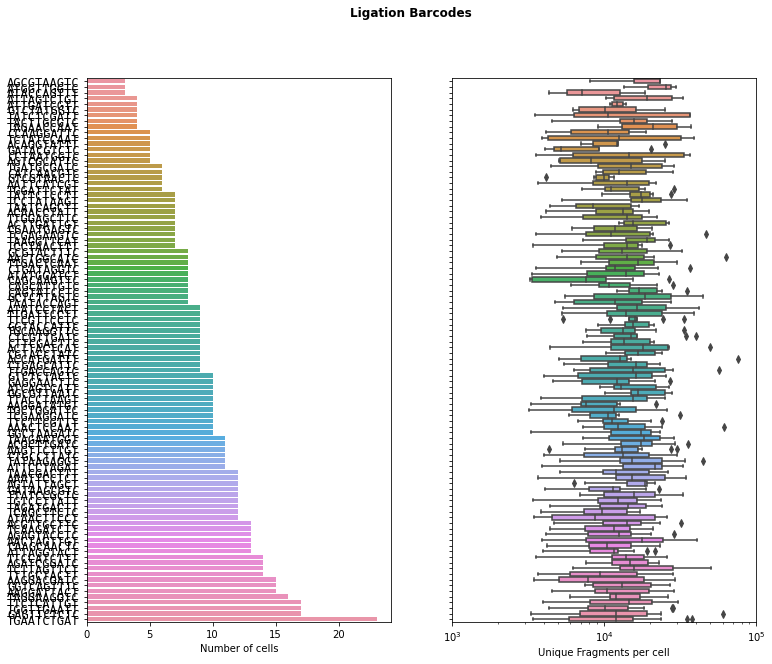

In [63]:
fig = plot_level(cellStats[cellStats['pass']], cellStats.ligInd[cellStats['pass']])
fig.suptitle("Ligation Barcodes", weight='semibold');


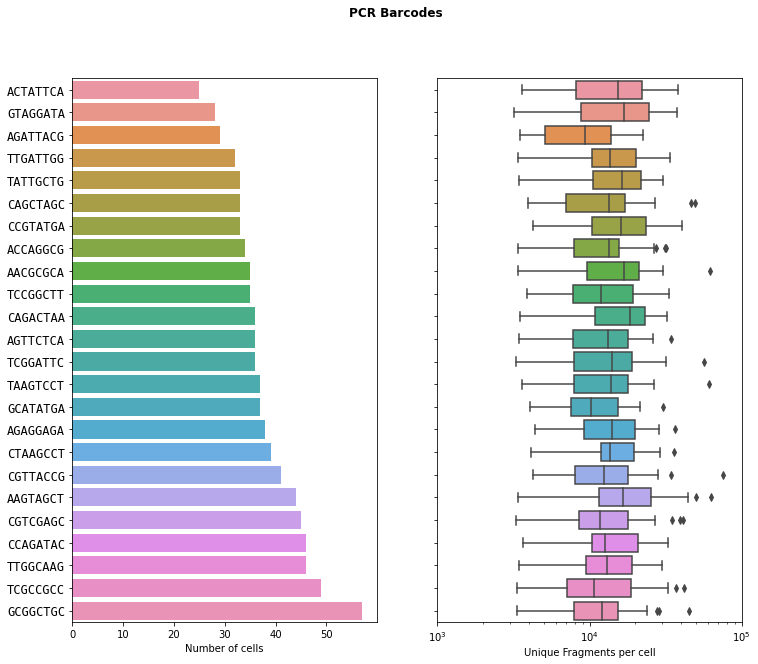

In [64]:
fig = plot_level(cellStats[cellStats['pass']], cellStats.pcrInd[cellStats['pass']])
fig.suptitle("PCR Barcodes", weight='semibold');
